In [1]:
import os.path
os.chdir("/scratch/users/sheetal/ProtTrans/Fine-Tuning")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
!pip install umap-learn
import umap

2024-01-23 09:23:56.842492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 09:23:57.210742: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 09:23:58.370295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-23 09:23:58.370534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.2
Pandas version:  2.1.3
Transformers version:  4.35.2
Datasets version:  2.15.0


In [4]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = './train_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q9UQC2|GAB2_HUMAN%598%614,SGTNSPAPKKSTGSVDYLALDFQPSSPSPHRKP,1
1,sp|P18031|PTN1_HUMAN%137%153,DTNLKLTLISEDIKSYYTVRQLELENLTTQETR,1
2,sp|P08581|MET_HUMAN%1340%1356,IFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSE,1
3,sp|P35968|VGFR2_HUMAN%980%996,EKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQV,1
4,sp|P35568|IRS1_HUMAN%880%896,QQQPLLHPPEPKSPGEYVNIEFGSDQSGYLSGP,1


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.head(5))

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.head(5))

Training Set:
                              sequence  label
198  RKNWKVRKFILREDPAYLHYYDPAGAEDPLGAI      0
38   NGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDT      1
24   CKIADFGLARVIEDNEYTAREGAKFPIKWTAPE      1
122  PGDVCCWICIPCEPYEYLADEFTCMDCGSGQWP      0
196  SEASQPKPCPPEVTPHYIWIDFLVQRFEIAKYC      0

Validation Set:
                              sequence  label
95   CRSGKGPILMELQTYRYHGHSMSDPGVSYRTRE      1
15   ISDFGLSKALRADENYYKAQTHGKWPVKWYAPE      1
30   PVSCMEEEEVCDPKFHYDNTAGISQYLQNSKRK      1
158  GDKPLSALDSQRKLQFYEDRHQLPAPKWAELAN      0
128  KESMAVFEQHCKMAQEYMKVQTEIALLLQRKQE      0


In [6]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [7]:
class ClassConfig:
    def __init__(self, dropout=0.9, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [8]:
def PT5_classification_model(num_labels):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [10]:
from sklearn.metrics import accuracy_score
!pip install seaborn
import seaborn as sns

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs= 10,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed= True,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

    def apply_umap(embeddings, n_components=2, min_dist=0.01):
        umap_model = umap.UMAP(n_components=n_components)
        umap_embeddings = umap_model.fit_transform(embeddings)
        return umap_embeddings

    def plot_umap(embeddings, labels):
        data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
        df = pd.DataFrame(data)
    
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette="flare", s=50, alpha=0.9)
        plt.title("UMAP Visualization of Embeddings")
        plt.show()
        
    # Train model
    trainer.train()

    valid_sequences = list(valid_df['sequence'])
    valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # Apply UMAP for dimensionality reduction
    umap_embeddings = apply_umap(valid_embeddings)

    # Plot UMAP embeddings
    labels = list(valid_df['label'])
    plot_umap(umap_embeddings, labels)

    return tokenizer, model, trainer.state.log_history


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426

[2024-01-23 09:25:41,541] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-01-23 09:25:42,087] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-01-23 09:25:42,088] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


 [WARNING]  cpu_adam cuda is missing or is incompatible with installed torch, only cpu ops can be compiled!


Using /home/centos/.cache/torch_extensions/py39_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/centos/.cache/torch_extensions/py39_cu121/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 3.1360654830932617 seconds


/scratch/users/anup/miniconda3/envs/test_new/lib/python3.9/site-packages/deepspeed/runtime/zero/stage_1_and_2.py:1221: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  total_norm_cuda = get_accelerator().FloatTensor([float(total_norm)])


Epoch,Training Loss,Validation Loss,Accuracy
1,0.723000,0.683840,0.560976
2,0.698600,0.671040,0.756098
3,0.676200,0.660624,0.707317
4,0.690400,0.651119,0.707317
5,0.645700,0.638168,0.731707
6,0.638300,0.622842,0.756098
7,0.602100,0.604928,0.756098
8,0.587400,0.573585,0.780488
9,0.588000,0.534199,0.756098
10,0.558100,0.502594,0.756098


Batch 1, Second-to-Last Layer Embeddings Shape: (32, 1024)
Batch 2, Second-to-Last Layer Embeddings Shape: (9, 1024)


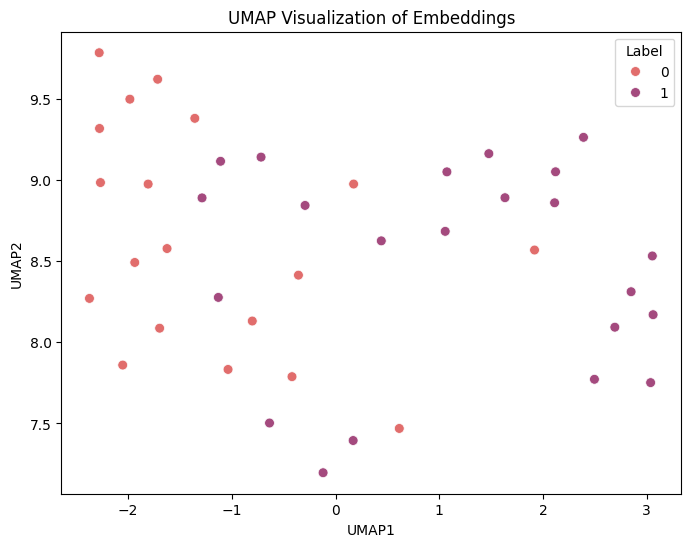

In [11]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=2, batch=1, accum=8, epochs=20, seed=42)

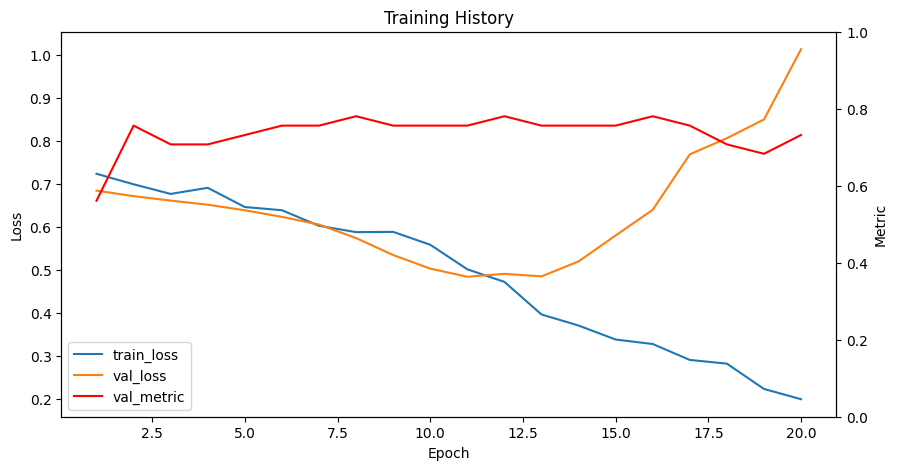

In [12]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

In [13]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [14]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

save_model(model, "./my_finetuned.pth")

In [15]:
tokenizer, model_reload = load_model("./my_finetuned.pth", num_labels=2)

ProtT5_Classfier
Trainable Parameter: 1209193474
ProtT5_LoRA_Classfier
Trainable Parameter: 3559426



In [16]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [17]:
from Bio import SeqIO
import pandas as pd

local_fasta_path = './test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P20963|CD3Z_HUMAN%126%142,IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM,1
1,sp|P00533|EGFR_HUMAN%1076%1092,ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP,1
2,sp|P08581|MET_HUMAN%1349%1365,YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT,1
3,sp|P09619|PGFRB_HUMAN%841%857,KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE,1
4,sp|Q13480|GAB1_HUMAN%573%589,VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG,1


In [18]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  IGMKGERRRGKGHDGLYQGLSTATKDTYDALHM      1
1  ALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNP      1
2  YVHVNATYVNVKCVAPYPSLLSSEDNADDEVDT      1
3  KICDFGLARDIMRDSNYISKGSTFLPLKWMAPE      1
4  VHSTTSSSDSHDSEENYVPMNPNLSSEDPNLFG      1


In [19]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.682692 |      0.807692 |         0.875 |       0.84 |  0.913462 |
+----------+---------------+---------------+------------+-----------+


In [20]:
# Regression
#print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

# Classification
# we need to determine the prediction class from the logit output
#predictions= [item.argmax() for item in np.array(predictions)]
#print("Accuracy: ", accuracy_score(my_test.label, predictions))


2024-01-23 10:21:32.327541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-23 10:21:32.454575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-23 10:21:32.456562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-23 10:21:32.460654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 128)           8320      
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            65600     
                                                                 
 dropout_1 (Dropout)         (None, 18, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 64)            0         
 1D)                                                    

2024-01-23 10:21:35.920168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8902
2024-01-23 10:21:36.193344: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5/5 [==============================] - 5s 220ms/step - loss: 0.7588 - accuracy: 0.4812 - auc_roc: 0.4576 - val_loss: 0.7080 - val_accuracy: 0.6098 - val_auc_roc: 0.5048
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: 0.7395 - accuracy: 0.4938 - auc_roc: 0.4991 - val_loss: 0.7148 - val_accuracy: 0.4878 - val_auc_roc: 0.5203
Epoch 3/20
5/5 [==============================] - 0s 31ms/step - loss: 0.6680 - accuracy: 0.5688 - auc_roc: 0.6234 - val_loss: 0.7040 - val_accuracy: 0.5122 - val_auc_roc: 0.5072
Epoch 4/20
5/5 [==============================] - 0s 30ms/step - loss: 0.6733 - accuracy: 0.5875 - auc_roc: 0.6080 - val_loss: 0.6967 - val_accuracy: 0.4878 - val_auc_roc: 0.4964
Epoch 5/20
5/5 [==============================] - 0s 31ms/step - loss: 0.6858 - accuracy: 0.5750 - auc_roc: 0.5877 - val_loss: 0.6942 - val_accuracy: 0.5610 - val_auc_roc: 0.5311
Epoch 6/20
5/5 [==============================] - 0s 26ms/step - loss: 0.6953 - accuracy: 0.5688 - auc_roc: 0.5708 

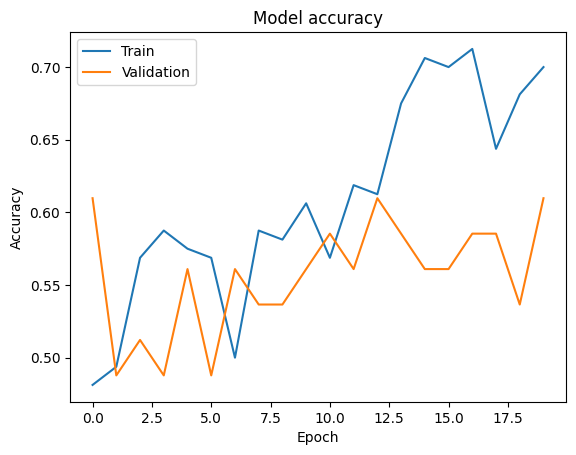

╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ Accuracy    │ 0.56     │
├─────────────┼──────────┤
│ AUC         │ 0.549679 │
├─────────────┼──────────┤
│ Sensitivity │ 0.291667 │
├─────────────┼──────────┤
│ Specificity │ 0.807692 │
├─────────────┼──────────┤
│ MCC         │ 0.11623  │
╘═════════════╧══════════╛


In [21]:
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Embedding, Lambda, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam


def CNN_model():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=16, activation='relu', kernel_initializer='he_normal', input_shape=(65, 4)))
    model.add(Dropout(0.4))       #########change to 0.9?
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=8, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model


def sequence_to_one_hot(sequence):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((len(sequence), 4))
    for i, aa in enumerate(sequence):
        if aa in mapping:
            one_hot[i, mapping[aa]] = 1
    return one_hot

def plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


my_train['sequence_cnn'] = my_train.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)
my_valid['sequence_cnn'] = my_valid.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)

# Extract sequences and labels for CNN
pre_train_ST_CNN = np.stack(my_train['sequence_cnn'].values)
pre_train_ST_CNN_labels = np.array(my_train['label'])

pre_valid_ST_CNN = np.stack(my_valid['sequence_cnn'].values)
pre_valid_ST_CNN_labels = np.array(my_valid['label'])

n_epo_cnn = 20
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
print(model_A.summary())
model_A.compile(optimizer=Adam(learning_rate=3e-4), loss=BinaryCrossentropy(), metrics=metrics)

print("PRE Training CNN model...")
print("Shape of pre_train_ST_CNN:", pre_train_ST_CNN.shape)
print("Shape of pre_valid_ST_CNN:", pre_valid_ST_CNN.shape)

checkpointer = ModelCheckpoint(filepath="./pre_model_A.h5", 
                                monitor="val_accuracy",
                                verbose=0,
                                save_weights_only=True,
                                save_best_only=True)






########### BATCH SIZE =1 or 32 instead of 1024
pre_history_A = model_A.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=32, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
                            validation_data=(pre_valid_ST_CNN, pre_valid_ST_CNN_labels))








# Convert sequences to suitable format for CNN (one-hot encoding, etc.)
my_test['sequence_cnn'] = my_test.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)

# Extract sequences and labels for CNN
pre_test_ST_CNN = np.stack(my_test['sequence_cnn'].values)
pre_test_ST_CNN_labels = np.array(my_test['label'])


# Load model for evaluation
loaded_model_A = CNN_model()
loaded_model_A.load_weights("./pre_model_A.h5")
y_pred_cnn = loaded_model_A.predict(pre_test_ST_CNN).reshape(pre_test_ST_CNN_labels.shape[0],)
y_pred_cnn = (y_pred_cnn > 0.5)
y_pred_cnn = [int(i) for i in y_pred_cnn]
pre_test_ST_CNN_labels = np.array(pre_test_ST_CNN_labels)
y_pred_cnn = np.array(y_pred_cnn)

# Evaluate CNN model on test set
cm_cnn = confusion_matrix(pre_test_ST_CNN_labels, y_pred_cnn)
mcc_cnn = matthews_corrcoef(pre_test_ST_CNN_labels, y_pred_cnn)
acc_cnn = accuracy_score(pre_test_ST_CNN_labels, y_pred_cnn)
roc_auc_cnn = roc_auc_score(pre_test_ST_CNN_labels, y_pred_cnn)

sn_cnn = cm_cnn[1][1] / (cm_cnn[1][1] + cm_cnn[1][0])
sp_cnn = cm_cnn[0][0] / (cm_cnn[0][0] + cm_cnn[0][1])

plot(pre_history_A)

#print("Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" % (str(acc_cnn), str(mcc_cnn), str(sn_cnn), str(sp_cnn), cm_cnn))
table_data = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_cnn)],
    ["AUC", str(roc_auc_cnn)],
    ["Sensitivity", str(sn_cnn)],
    ["Specificity", str(sp_cnn)],
    ["MCC", str(mcc_cnn)],
]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))


Shape: (160,)
PRE Training LSTM model...
Epoch 1/20
5/5 [==============================] - 4s 283ms/step - loss: 0.6924 - accuracy: 0.5063 - auc_roc: 0.4930 - val_loss: 0.6966 - val_accuracy: 0.4634 - val_auc_roc: 0.5275
Epoch 2/20
5/5 [==============================] - 1s 111ms/step - loss: 0.6916 - accuracy: 0.5312 - auc_roc: 0.5157 - val_loss: 0.6961 - val_accuracy: 0.4878 - val_auc_roc: 0.5754
Epoch 3/20
5/5 [==============================] - 0s 103ms/step - loss: 0.6850 - accuracy: 0.5375 - auc_roc: 0.6124 - val_loss: 0.6956 - val_accuracy: 0.4878 - val_auc_roc: 0.5670
Epoch 4/20
5/5 [==============================] - 1s 116ms/step - loss: 0.6850 - accuracy: 0.5000 - auc_roc: 0.5595 - val_loss: 0.6952 - val_accuracy: 0.4878 - val_auc_roc: 0.5993
Epoch 5/20
5/5 [==============================] - 1s 111ms/step - loss: 0.6864 - accuracy: 0.5188 - auc_roc: 0.5627 - val_loss: 0.6947 - val_accuracy: 0.4634 - val_auc_roc: 0.5981
Epoch 6/20
5/5 [==============================] - 1s 114ms/

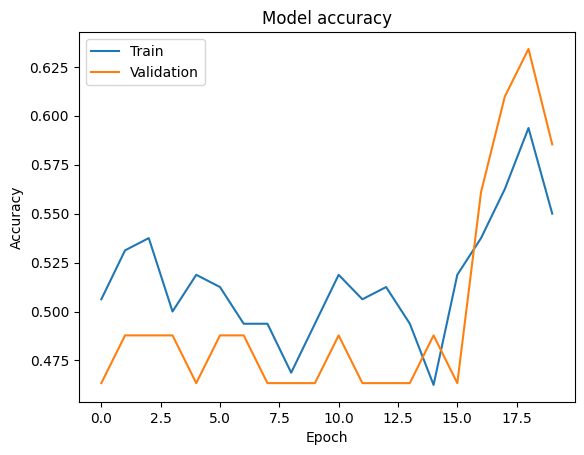

╒═════════════╤═══════════╕
│ Metric      │     Value │
╞═════════════╪═══════════╡
│ Accuracy    │ 0.54      │
├─────────────┼───────────┤
│ AUC         │ 0.535256  │
├─────────────┼───────────┤
│ Sensitivity │ 0.416667  │
├─────────────┼───────────┤
│ Specificity │ 0.653846  │
├─────────────┼───────────┤
│ MCC         │ 0.0725776 │
╘═════════════╧═══════════╛


In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from tabulate import tabulate

def LSTM_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(65, 4), activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model




# ... (code for data preprocessing from CNN)
my_train['sequence_lstm'] = my_train.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)
my_valid['sequence_lstm'] = my_valid.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)

# Extract sequences and labels for LSTM
pre_train_ST_LSTM = np.stack(my_train['sequence_lstm'].values)
pre_train_ST_LSTM_labels = np.array(my_train['label'])

print("Shape:", pre_train_ST_LSTM_labels.shape)

pre_valid_ST_LSTM = np.stack(my_valid['sequence_lstm'].values)
pre_valid_ST_LSTM_labels = np.array(my_valid['label'])

n_epo_lstm = 20
metrics_lstm = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_lstm = LSTM_model()
model_lstm.compile(optimizer=Adam(learning_rate=3e-4), loss=BinaryCrossentropy(), metrics=metrics_lstm)

print("PRE Training LSTM model...")

checkpointer_lstm = ModelCheckpoint(filepath="./pre_model_lstm.h5", 
                                     monitor="val_accuracy",
                                     verbose=0,
                                     save_weights_only=True,
                                     save_best_only=True)

pre_history_lstm = model_lstm.fit(pre_train_ST_LSTM, pre_train_ST_LSTM_labels, batch_size=32, epochs=n_epo_lstm, verbose=1, callbacks=[checkpointer_lstm],
                                  validation_data=(pre_valid_ST_LSTM, pre_valid_ST_LSTM_labels))

# Convert sequences to suitable format for LSTM (one-hot encoding, etc.)
my_test['sequence_lstm'] = my_test.apply(lambda row: sequence_to_one_hot(row["sequence"]), axis=1)

# Extract sequences and labels for LSTM
pre_test_ST_LSTM = np.stack(my_test['sequence_lstm'].values)
pre_test_ST_LSTM_labels = np.array(my_test['label'])

# Load model for evaluation
loaded_model_lstm = LSTM_model()
loaded_model_lstm.load_weights("./pre_model_lstm.h5")
y_pred_lstm = loaded_model_lstm.predict(pre_test_ST_LSTM).reshape(pre_test_ST_LSTM_labels.shape[0],)
y_pred_lstm = (y_pred_lstm > 0.5)
y_pred_lstm = [int(i) for i in y_pred_lstm]
pre_test_ST_LSTM_labels = np.array(pre_test_ST_LSTM_labels)
y_pred_lstm = np.array(y_pred_lstm)

# Evaluate LSTM model on test set
cm_lstm = confusion_matrix(pre_test_ST_LSTM_labels, y_pred_lstm)
mcc_lstm = matthews_corrcoef(pre_test_ST_LSTM_labels, y_pred_lstm)
acc_lstm = accuracy_score(pre_test_ST_LSTM_labels, y_pred_lstm)
roc_auc_lstm = roc_auc_score(pre_test_ST_LSTM_labels, y_pred_lstm)

sn_lstm = cm_lstm[1][1] / (cm_lstm[1][1] + cm_lstm[1][0])
sp_lstm = cm_lstm[0][0] / (cm_lstm[0][0] + cm_lstm[0][1])

plot(pre_history_lstm)

table_data_lstm = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_lstm)],
    ["AUC", str(roc_auc_lstm)],
    ["Sensitivity", str(sn_lstm)],
    ["Specificity", str(sp_lstm)],
    ["MCC", str(mcc_lstm)],
]

# Print the table
print(tabulate(table_data_lstm, headers="firstrow", tablefmt="fancy_grid"))


Epoch 1/20
5/5 [==============================] - 7s 424ms/step - loss: 2.6509 - accuracy: 0.4437 - val_loss: 1.0180 - val_accuracy: 0.5366
Epoch 2/20
5/5 [==============================] - 0s 52ms/step - loss: 1.0498 - accuracy: 0.4875 - val_loss: 0.7273 - val_accuracy: 0.4634
Epoch 3/20
5/5 [==============================] - 0s 48ms/step - loss: 1.0441 - accuracy: 0.4688 - val_loss: 1.2270 - val_accuracy: 0.5366
Epoch 4/20
5/5 [==============================] - 0s 46ms/step - loss: 0.8577 - accuracy: 0.4375 - val_loss: 1.9360 - val_accuracy: 0.5366
Epoch 5/20
5/5 [==============================] - 0s 47ms/step - loss: 0.8238 - accuracy: 0.5000 - val_loss: 1.6097 - val_accuracy: 0.5366
Epoch 6/20
5/5 [==============================] - 0s 48ms/step - loss: 0.7661 - accuracy: 0.4750 - val_loss: 0.9575 - val_accuracy: 0.5366
Epoch 7/20
5/5 [==============================] - 0s 49ms/step - loss: 0.8019 - accuracy: 0.4750 - val_loss: 0.8772 - val_accuracy: 0.5366
Epoch 8/20
5/5 [==========

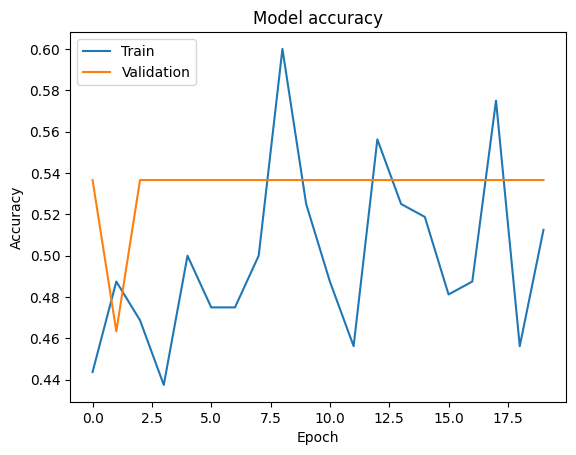

╒═════════════╤═════════╕
│ Metric      │   Value │
╞═════════════╪═════════╡
│ Accuracy    │    0.48 │
├─────────────┼─────────┤
│ AUC         │    0.5  │
├─────────────┼─────────┤
│ Sensitivity │    1    │
├─────────────┼─────────┤
│ Specificity │    0    │
├─────────────┼─────────┤
│ MCC         │    0    │
╘═════════════╧═════════╛


In [27]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, LayerNormalization, Embedding
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from keras.utils import to_categorical


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.9):
        super(TransformerBlock, self).__init__()
        self.att = Attention(use_scale=True, dropout=rate)
        self.ffn = keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.linear_transform = Dense(embed_dim)

    def call(self, inputs, training):
        attn_output = self.att([inputs, inputs])
        attn_output = self.dropout1(attn_output, training=training)

        linear_transform_output = self.linear_transform(inputs)
        linear_transform_output = tf.reduce_mean(linear_transform_output, axis=-1, keepdims=True)

        concat_output = attn_output + linear_transform_output
        concat_output = self.layernorm1(concat_output, training=training)

        ffn_output = self.ffn(concat_output)
        ffn_output = self.dropout2(ffn_output, training=training)

        output = self.layernorm2(concat_output + ffn_output)

        return output








class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=max_len, output_dim=embed_dim)

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x) + positions  # Ensure correct addition here
        return x


class TransformerModel(tf.keras.models.Model):
    def __init__(self, max_len, vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate, num_classes):
        super(TransformerModel, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embedding_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        self.token_and_position_embedding = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_transformer_blocks)]
        self.global_average_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dropout = Dropout(dropout_rate)

        # Change the output layer to have 2 neurons for binary classification
        self.out = Dense(2, activation='softmax')

    def build_model(self, input_shape):
        self.token_and_position_embedding = TokenAndPositionEmbedding(input_shape, self.max_len, self.embedding_dim)
        self.transformer_blocks = [TransformerBlock(self.embedding_dim, self.num_heads, self.ff_dim) for _ in range(self.num_transformer_blocks)]
        self.dropout = tf.keras.layers.Dropout(0.1)
        # Modify the output layer for binary classification
        self.out = tf.keras.layers.Dense(2, activation='softmax')  # Change 'softmax' based on your problem

    def call(self, inputs, training=False):
        x = self.token_and_position_embedding(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training)
        x = tf.reduce_mean(x, axis=1)
        x = self.dropout(x, training=training)

        # Add the Dense layer for classification
        x = self.out(x)
        
        return x



num_classes = 2
# Data preparation 
max_len = 33
vocab_size = 21
embed_dim = 128
num_heads = 2
ff_dim = 128
num_transformer_blocks = 3
dropout_rate = 0.6   ################################## changed



pre_train_ST_transformer_sequences = my_train['sequence'].apply(lambda seq: sequence_to_one_hot(seq))
pre_train_ST_transformer = np.stack(pre_train_ST_transformer_sequences)
pre_train_ST_transformer_labels = np.array(my_train['label'])  # Keep labels as 1D array for SparseCategoricalCrossentropy


pre_train_ST_transformer_labels = to_categorical(pre_train_ST_transformer_labels, num_classes=num_classes)



pre_valid_ST_transformer_sequences = my_valid['sequence'].apply(lambda seq: sequence_to_one_hot(seq))
pre_valid_ST_transformer = np.stack(pre_valid_ST_transformer_sequences)
pre_valid_ST_transformer_labels = np.array(my_valid['label'])  # Keep labels as 1D array for SparseCategoricalCrossentropy

pre_valid_ST_transformer_labels = to_categorical(pre_valid_ST_transformer_labels, num_classes=num_classes)


pre_test_ST_transformer_sequences = my_test['sequence'].apply(lambda seq: sequence_to_one_hot(seq))
pre_test_ST_transformer = np.stack(pre_test_ST_transformer_sequences)
pre_test_ST_transformer_labels = np.array(my_test['label'])

pre_test_ST_transformer_labels = to_categorical(pre_test_ST_transformer_labels, num_classes=num_classes)

n_epo_transformer = 20
metrics_transformer = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_transformer = TransformerModel(max_len, vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate, num_classes)
model_transformer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Training
checkpointer_transformer = ModelCheckpoint(
    filepath="./pre_model_transformer.h5",
    monitor="val_accuracy",
    verbose=0,
    save_weights_only=True,
    save_best_only=True
)

'''
print("Shape of pre_train_ST_transformer_labels before training:", pre_train_ST_transformer_labels.shape)
print("Shape of pre_valid_ST_transformer_labels before training:", pre_valid_ST_transformer_labels.shape)
print("Shape of pre_train_ST_transformer before training:", pre_train_ST_transformer.shape)
print("Shape of pre_valid_ST_transformer before training:", pre_valid_ST_transformer.shape)
print("Shape of pre_test_ST_transformer before training:", pre_test_ST_transformer.shape)
print("Shape of pre_test_ST_transformer_labels before training:", pre_test_ST_transformer_labels.shape)

'''

# Training loop
pre_train_ST_transformer_reshaped = pre_train_ST_transformer.reshape((pre_train_ST_transformer.shape[0], -1))

history = model_transformer.fit(
    pre_train_ST_transformer_reshaped, pre_train_ST_transformer_labels,
    batch_size=32, epochs=n_epo_transformer, verbose=1,
    callbacks=[checkpointer_transformer],
    validation_data=(pre_valid_ST_transformer.reshape((pre_valid_ST_transformer.shape[0], -1)), pre_valid_ST_transformer_labels)
)


pre_test_ST_transformer_reshaped = pre_test_ST_transformer.reshape((pre_test_ST_transformer.shape[0], -1))

# Model evaluation on test set
loaded_model_transformer = TransformerModel(
    max_len, vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate, num_classes
)

loaded_model_transformer.build((None, max_len))

loaded_model_transformer.load_weights("./pre_model_transformer.h5")

# Use the model's predict method directly
y_pred_transformer = loaded_model_transformer.predict(pre_test_ST_transformer_reshaped)

y_pred_transformer = (y_pred_transformer > 0.5)


# Convert one-hot encoded predictions to integer labels
y_pred_labels = np.argmax(y_pred_transformer, axis=1)

# Convert one-hot encoded true labels to integer labels
true_labels = np.argmax(pre_test_ST_transformer_labels, axis=1)


# Model evaluation metrics (you need to replace this with your actual evaluation code)
cm_transformer = confusion_matrix(true_labels, y_pred_labels)
mcc_transformer = matthews_corrcoef(true_labels, y_pred_labels)
acc_transformer = accuracy_score(true_labels, y_pred_labels)
roc_auc_transformer = roc_auc_score(true_labels, y_pred_labels)

sn_transformer = cm_transformer[1][1] / (cm_transformer[1][1] + cm_transformer[1][0])
sp_transformer = cm_transformer[0][0] / (cm_transformer[0][0] + cm_transformer[0][1])

# Plot training history
plot(history)

# Display evaluation metrics in a table
table_data_transformer = [
    ["Metric", "Value"],
    ["Accuracy", str(acc_transformer)],
    ["AUC", str(roc_auc_transformer)],
    ["Sensitivity", str(sn_transformer)],
    ["Specificity", str(sp_transformer)],
    ["MCC", str(mcc_transformer)],
]

# Print the table
print(tabulate(table_data_transformer, headers="firstrow", tablefmt="fancy_grid"))


